<a href="https://colab.research.google.com/github/gremlin97/Turion/blob/main/SegNext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SegNext
***Model:*** I create an updated and advanced version of SegNet inspired by UNet. We have seen that segnet is composed of an encoder-decoder architecture. Here we apply successive enoder layers, with filters ranging from *32,64,128 and 256* for each block. The model architecures has double convolutions followed by **BN-ReLU** (inspired by VGG16). For the decoder we applied normal convolution filters and upsample the images by using Max Unpooling. To apply this operation we make use the pooling indices after pooling and initial image sizes before pooling.

***Features:*** For **SegNext**, first we replace the unpooling and normal convolution operations with transpose convolutions(ConvTranspose2d). The encoder block is left as it is as its goal is to downsample and encode the image into a latent space whilst increasing its receptive field beyond the input size. We could have/possibly used a pretrained backbone (ResNet-50) for better performance. We also take inspiration from UNet to add residual/skip connections through concetanation, from the encoder to its corresponding decoder stage. We may also make use of 1x1 to reduce the number of channels. Currently we make use of 3x3 convolutions for the same.

***Dataset:*** The dataset is a collection of satellite images for object detection and segmentation, using both synthesized and real images. It contains 3116 images, each with a mask of size 1280x720 and bounding boxes. Each satellite is segmented into at most 3 parts, namely body, solar panel, and antenna, represented respectively by the colors green, red, and blue. Images from index 0 to 1002 have fine masks, while those from index 1003 to 3116 have coarse masks. The dataset is divided into two parts: a train set that includes 403 fine masks and 2114 coarse masks, and a validation set with 600 fine masks. The bounding boxes for all satellites are available in the file "all_bbox.txt," which is in the form of a dictionary with image index as the key and the bounding boxes represented as [max_x, max_y, min_x, min_y].

* *Link:* https://drive.google.com/drive/u/0/folders/1Q1wR9aBFCyeFEYa3wwyXNu9wk_fZdzUm

I only make use of the fine masks for training the segmentation model i.e 403 datapoints/images. In the future I will make use of all the 3k masks and images for training.




In [ ]:
# Downloading and extracting the space parts segmentation dataset
!pip install gdown
!pip install grad-cam
!gdown --id 1S_qPoxgGNiDVtjDytY62f1Vk5WSyr4OJ
!unzip -q Final_dataset.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38262 sha256=15c9a731b88c922ec8f4b3caf96986f9b24dabc0e848b76ffbe2ebbb42bf4807
  Stored in directory: /root/.cache/pip/wheels/9b/ae/bd/221d138b169c4867b2ae5c893474d0b23bae6e4750bc95bc55
Successfully built grad-cam
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1S_qPoxgGNiDVtjDytY62f1Vk5WSyr4O

In [ ]:
!pip install torch-lr-finder # Installing Pytorch LR Finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!rm -rf /content/Final_dataset/images/train/.DS_Store # removing the extra/redundant file

In [ ]:
# Importing essential libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image

In [ ]:
dir = '/content/Final_dataset'
transform = transforms.Compose([
                           transforms.Resize((256,256)),
                           transforms.ToTensor(),# Convert to Tensor,
                           transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                           transforms.RandomRotation(degrees=7)
                          #  transforms.Normalize((0.2212,), (0.2413,))
                           ])
# target_transform = transforms.Compose([
#                            transforms.Resize((256,256)),
#                            transforms.RandomHorizontalFlip(p=0.5),
#                            transforms.ToTensor(),# Convert to Tensor,
#                            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
#                            transforms.RandomRotation(degrees=7)
#                           #  transforms.Normalize((0.2212,), (0.2413,))
#                            ])

In [ ]:
# Checking length of the training set and the corresponding masks
len(list(os.listdir(dir + '/images/train'))), len(list(os.listdir(dir + '/mask/train')))

(2517, 2517)

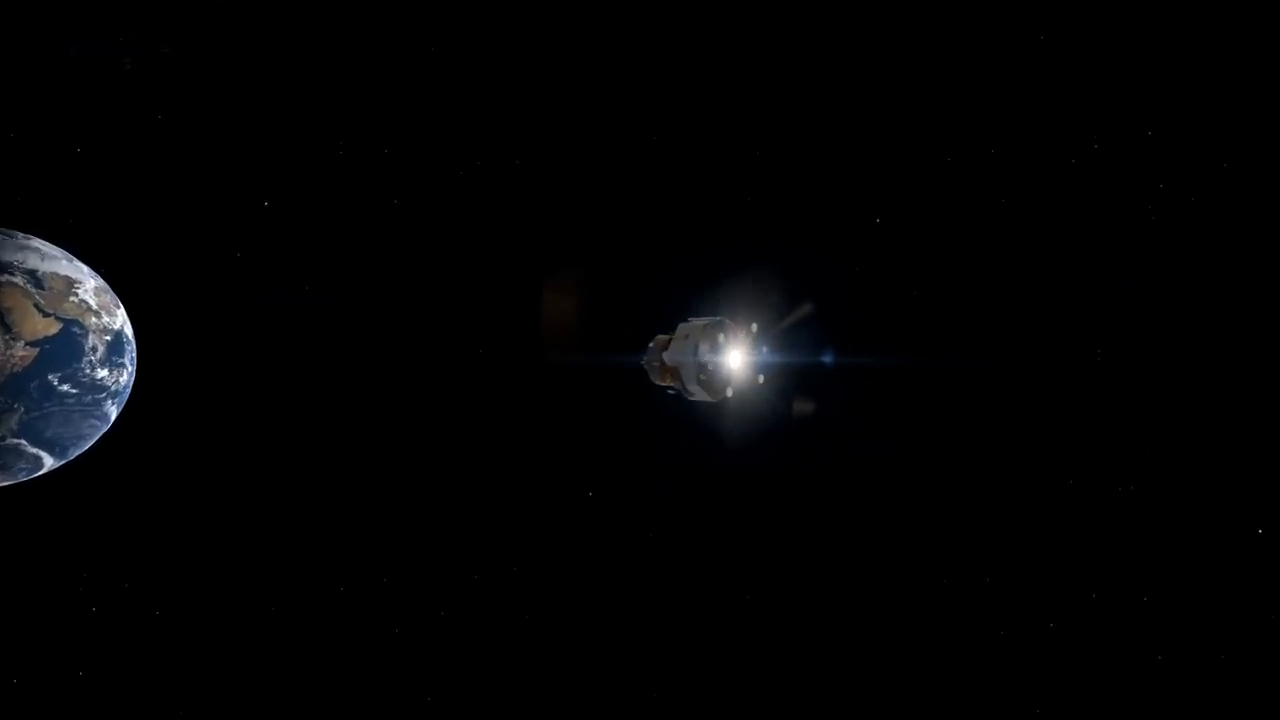

In [ ]:
# Sampling an image from the training set
par_img_path = list(os.listdir(dir + '/images/train'))[0]
img_path = dir + '/images/train'+ '/' +par_img_path
img = Image.open(img_path)
img.show()

### Dataset

The dataset is a collection of satellite images for object detection and segmentation, using both synthesized and real images. It contains 3116 images, each with a mask of size 1280x720 and bounding boxes. Each satellite is segmented into at most 3 parts, namely body, solar panel, and antenna, represented respectively by the colors green, red, and blue. Images from index 0 to 1002 have fine masks, while those from index 1003 to 3116 have coarse masks. The dataset is divided into two parts: a train set that includes 403 fine masks and 2114 coarse masks, and a validation set with 600 fine masks. The bounding boxes for all satellites are available in the file "all_bbox.txt," which is in the form of a dictionary with image index as the key and the bounding boxes represented as [max_x, max_y, min_x, min_y].

* *Link:* https://drive.google.com/drive/u/0/folders/1Q1wR9aBFCyeFEYa3wwyXNu9wk_fZdzUm

I only make use of the fine masks for training the segmentation model i.e 403 datapoints/images. In the future I will make use of all the 3k masks and images for training. The validation, and training datapoint counts have been mentioned above. 

In [ ]:
"""
The SatelliteSeg class is a custom dataset class for PyTorch that loads satellite image segmentation data. 
It takes in a directory where the data is stored and a transformation to apply to the data, and returns preprocessed data as PyTorch tensors.

The __len__ method returns the number of images in the dataset
The __getitem__ method loads and preprocesses the image and mask at a given index, using the directory and transformation specified in the constructor.

To use this class, create an instance of it and pass it to a PyTorch dataloader.

"""

class SatelliteSeg(Dataset):
  def __init__(self, dir, transform, train=True):
    self.dir = dir
    # self.train_dir = dir + '/images/train'
    # self.train_mask = dir + '/mask/train'
    self.transform = transform

    if train:
      self.data_dir = dir + '/images/train'
      self.mask_dir = dir + '/mask/train'
    else:
      self.data_dir = dir + '/images/val'
      self.mask_dir = dir + '/mask/val'
    
  def __len__(self):
    self.img_path = list(os.listdir(self.data_dir))[:403]
    #self.img_path = list(os.listdir(self.data_dir))
    return len(self.img_path)

  def __getitem__(self, idx):
    img = self.data_dir + '/' + f'img_resize_{idx}.png'
    mask = self.mask_dir + '/' + f'img_resize_{idx}_mask.png'

    img = Image.open(img).convert('RGB')
    mask = Image.open(mask).convert('RGB')

    mask = mask.resize((256,256), resample=Image.NEAREST)

    mask_array = np.array(mask)
    label = torch.zeros((mask_array.shape[0], mask_array.shape[1]), dtype=torch.uint8)
    label[(mask_array == np.array([255, 0, 0])).all(axis=2)] = 1  # red class
    label[(mask_array == np.array([0, 255, 0])).all(axis=2)] = 2  # green class
    label[(mask_array == np.array([0, 0, 255])).all(axis=2)] = 3  # blue class

    label = label.type(torch.LongTensor)
  
    if self.transform:
      img = self.transform(img)

    return img, label

# Creating train dataset
train = SatelliteSeg(dir, transform)    

In [ ]:
# Created validation dataset
val = SatelliteSeg(dir, transform, train=False)
val_loader = DataLoader(val, batch_size=4, drop_last=True)

In [ ]:
# Checking size of img and seg tensor returned from the custom dataset. Some more Sanity check done below
img, mask = next(iter(train))
img.size(), mask.size()

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

In [ ]:
torch.max(mask), type(mask)

(tensor(2), torch.Tensor)

In [ ]:
len(train)

403

In [ ]:
# Creating trainloader
train_loader = DataLoader(train, batch_size=4, drop_last=True)

In [ ]:
# =========== Code to calculate train dataloader mean and std  ===========#

# mean = 0.
# meansq = 0.
# for i, (data,mask) in enumerate(train_loader):
#     mean = data.mean()
#     meansq = (data**2).mean()

# std = torch.sqrt(meansq - mean**2)
# print("mean: " + str(mean))
# print("std: " + str(std))
# print()

In [ ]:
imgs, masks = next(iter(train_loader))
imgs.size(), masks.size()

(torch.Size([4, 3, 256, 256]), torch.Size([4, 256, 256]))

### SegNext Model Class

***Model:*** I create an updated and advanced version of SegNet inspired by UNet. We have seen that segnet is composed of an encoder-decoder architecture. Here we apply successive enoder layers, with filters ranging from *32,64,128 and 256* for each block. The model architecures has double convolutions followed by **BN-ReLU** (inspired by VGG16). For the decoder we applied normal convolution filters and upsample the images by using Max Unpooling. To apply this operation we make use the pooling indices after pooling and initial image sizes before pooling.

***Features:*** For **SegNext**, first we replace the unpooling and normal convolution operations with transpose convolutions(ConvTranspose2d). The encoder block is left as it is as its goal is to downsample and encode the image into a latent space whilst increasing its receptive field beyond the input size. We could have/possibly used a pretrained backbone (ResNet-50) for better performance. We also take inspiration from UNet to add residual/skip connections through concetanation, from the encoder to its corresponding decoder stage. We may also make use of 1x1 to reduce the number of channels. Currently we make use of 3x3 convolutions for the same.

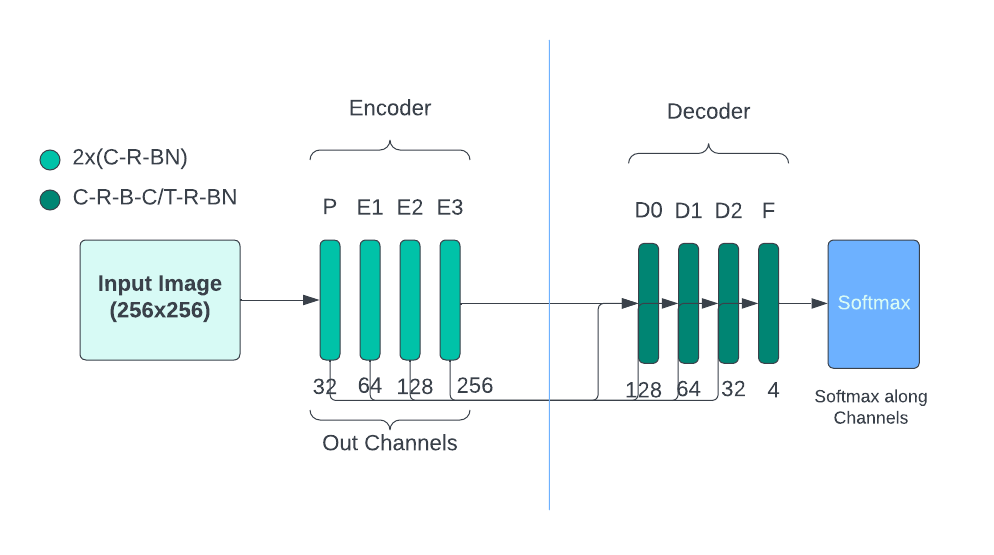

In [ ]:
class SegNext(nn.Module):
  def __init__(self):
    super().__init__()

    self.prep = nn.Sequential(
        nn.Conv2d(3,32,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(32)
    )

    self.prep_con = nn.Sequential(
        nn.Conv2d(32,32,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(32)
    )

    self.enc1 = nn.Sequential(
        nn.Conv2d(32,64,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(64)
    ) 

    self.enc1_con = nn.Sequential(
        nn.Conv2d(64,64,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(64)
    )

    self.enc2 = nn.Sequential(
        nn.Conv2d(64,128,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(128)
    )

    self.enc2_con = nn.Sequential(
        nn.Conv2d(128,128,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(128)
    )

    self.enc3 = nn.Sequential(
        nn.Conv2d(128,256,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(256)
    )

    self.enc3_con = nn.Sequential(
        nn.Conv2d(256,256,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(256)
    )

    self.dec0 = nn.Sequential(
        nn.Conv2d(512,256,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.ConvTranspose2d(256,128,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(128)
    )  

    self.dec1 = nn.Sequential(
        nn.Conv2d(256,128,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.ConvTranspose2d(128,64,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(64)
    )  


    self.dec2 = nn.Sequential(
        nn.Conv2d(128,64,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64,32,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(32)
    )  

    self.final = nn.Sequential(
        nn.Conv2d(64,32,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.ConvTranspose2d(32,4,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(4)
    )

  def forward(self, x):
    in_size = x.size()
    x = self.prep(x)
    e1 = self.prep_con(x)
    x = self.enc1(e1)
    e2 = self.enc1_con(x)
    x = self.enc2(e2)
    e3 = self.enc2_con(x)
    x = self.enc3(e3)
    e4 = self.enc3_con(x)
    x = torch.cat((e4,x), 1)
    x = self.dec0(x)
    x = torch.cat((e3,x),1)
    x = self.dec1(x)
    x = torch.concat((e2,x),1)
    x = self.dec2(x)
    x = torch.concat((e1,x),1)
    x = self.final(x)

    return x

In [ ]:
# Instantiated Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Instantiated Model
model = SegNext()

In [ ]:
# Sanity checks on the model
out = model(torch.rand(2,3,32,32))

In [ ]:
# Model summary
from torchsummary import summary
summary(model.to(device),(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 64, 32, 32]          18,496
              ReLU-8           [-1, 64, 32, 32]               0
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,928
             ReLU-11           [-1, 64, 32, 32]               0
      BatchNorm2d-12           [-1, 64, 32, 32]             128
           Conv2d-13          [-1, 128, 32, 32]          73,856
             ReLU-14          [-1, 128,

### Issues with low GPU memory

Faced multiple issues w.r.t to GPU memory hence tried to clear cache below. Low memory prevented me from using LR Finder as well as One Cycle Policy. Maybe using lower quantization through mixed precision training could have circumvented this issue.

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# from torch_lr_finder import LRFinder
# # define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(train_loader, end_lr=1, num_iter=100)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
# Defining hyperparameters
lr = 1e-03
num_epochs = 100
batch_size = 4


# Training loop
for epoch in range(num_epochs):
    # set model to training mode
    model.train()

    # initialize loss and accuracy
    epoch_loss = 0.0
    epoch_acc = 0.0

    # loop over training batches
    for images, masks in train_loader:
        # send data to device
        images = images.to(device)
        masks = masks.to(device)

        # zero gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(images)

        # calculate loss
        loss = criterion(outputs, masks)

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()

        # calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        # correct = (predicted == masks).all(dim=1).sum().item()
        # accuracy = correct / (batch_size * images.shape[2] * images.shape[3])

        # update epoch loss and accuracy
        epoch_loss += loss.item() * images.shape[0]
        # epoch_acc += accuracy * images.shape[0]

    # normalize epoch loss and accuracy
    epoch_loss /= len(train)
    epoch_acc /= len(train)

    # print epoch results
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")  
    # , Train Acc: {epoch_acc:.4f}

Epoch 1/100, Train Loss: 1.2105
Epoch 2/100, Train Loss: 0.8498
Epoch 3/100, Train Loss: 0.6925
Epoch 4/100, Train Loss: 0.5998
Epoch 5/100, Train Loss: 0.5421
Epoch 6/100, Train Loss: 0.5016
Epoch 7/100, Train Loss: 0.4766
Epoch 8/100, Train Loss: 0.4569
Epoch 9/100, Train Loss: 0.4400
Epoch 10/100, Train Loss: 0.4251
Epoch 11/100, Train Loss: 0.4155
Epoch 12/100, Train Loss: 0.4067
Epoch 13/100, Train Loss: 0.3967
Epoch 14/100, Train Loss: 0.3952
Epoch 15/100, Train Loss: 0.3875
Epoch 16/100, Train Loss: 0.3826
Epoch 17/100, Train Loss: 0.3742
Epoch 18/100, Train Loss: 0.3697
Epoch 19/100, Train Loss: 0.3626
Epoch 20/100, Train Loss: 0.3599
Epoch 21/100, Train Loss: 0.3561
Epoch 22/100, Train Loss: 0.3490
Epoch 23/100, Train Loss: 0.3433
Epoch 24/100, Train Loss: 0.3384
Epoch 25/100, Train Loss: 0.3343
Epoch 26/100, Train Loss: 0.3263
Epoch 27/100, Train Loss: 0.3262
Epoch 28/100, Train Loss: 0.3234
Epoch 29/100, Train Loss: 0.3228
Epoch 30/100, Train Loss: 0.3201
Epoch 31/100, Train

In [ ]:
# Plotting model output results. Model is currently only tested on the training dataset. In the future proper checks will be implemented

import matplotlib.pyplot as plt
import numpy as np

def show_out(train,i):
    # Load an image and corresponding mask
    image, mask = train[i]

    image = image.to(device)
    mask = mask.to(device)

    # Apply the model to the image
    output = model(image.unsqueeze(0))

    # Get the predicted segmentation labels
    predicted_labels = output.argmax(dim=1)

    # Convert predicted labels to a numpy array
    predicted_labels_np = predicted_labels[0].cpu().numpy()

    # Display the input image, ground truth mask, and predicted mask
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

    # Plot input image
    ax[0].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
    ax[0].set_title('Input Image')

    # Plot ground truth mask
    ax[1].imshow(mask.squeeze().cpu().numpy())
    ax[1].set_title('Ground Truth Mask')

    # Plot predicted mask
    ax[2].imshow(predicted_labels_np)
    ax[2].set_title('Predicted Mask')
    plt.show()

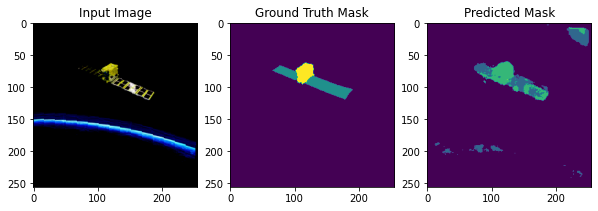

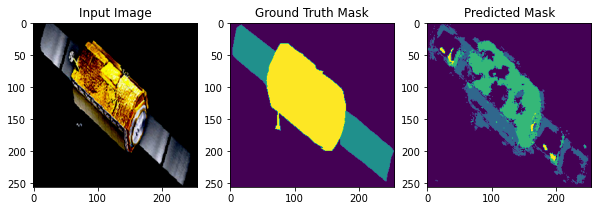

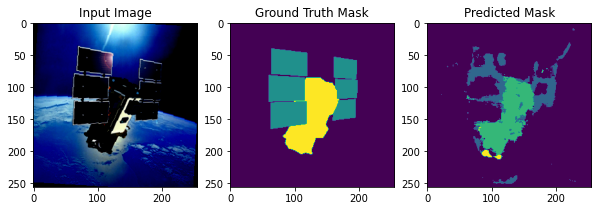

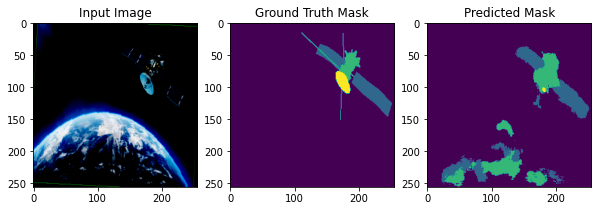

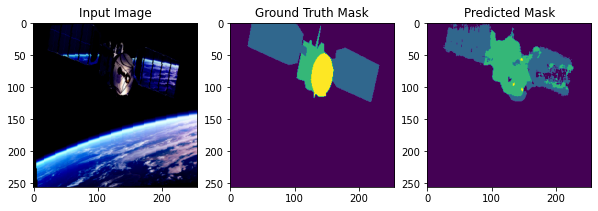

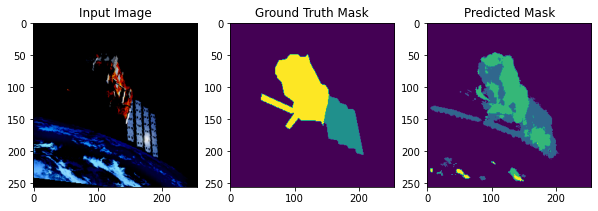

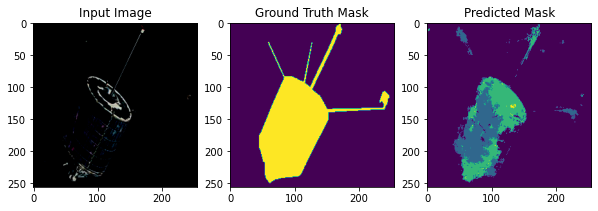

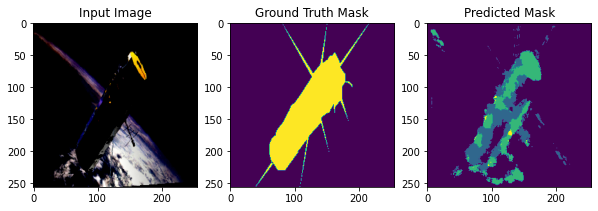

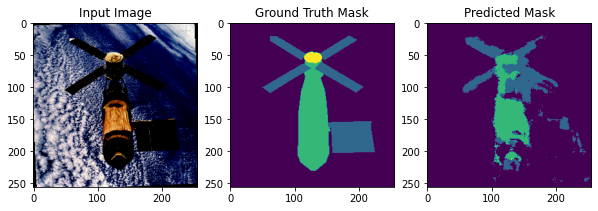

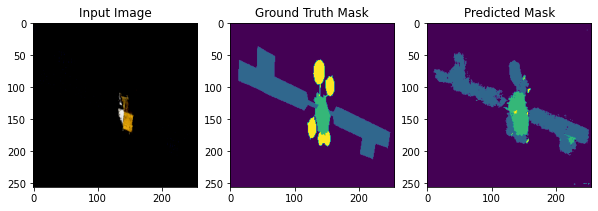

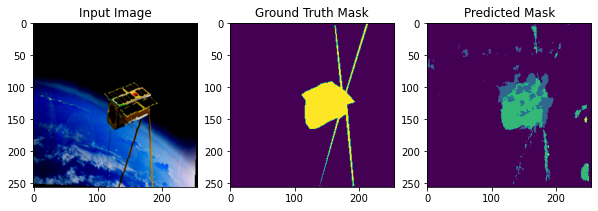

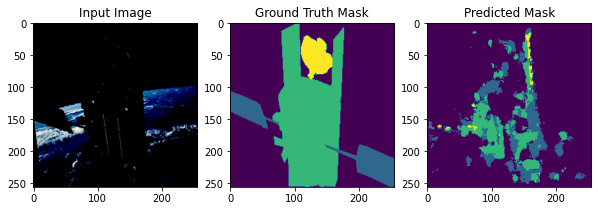

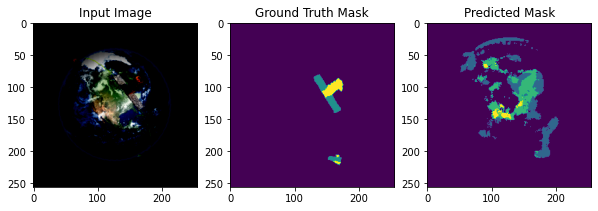

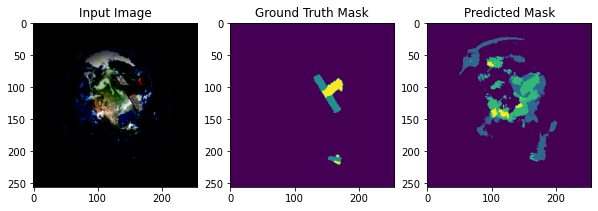

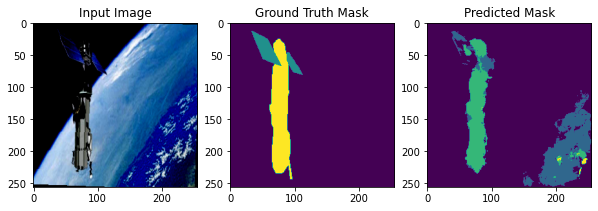

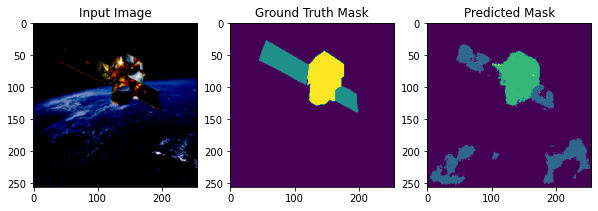

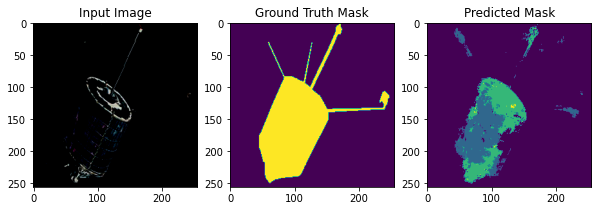

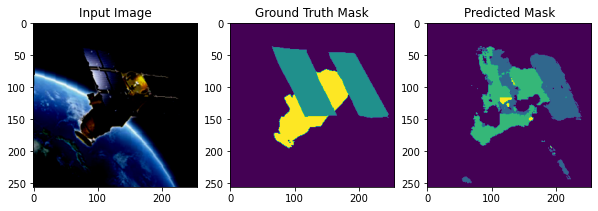

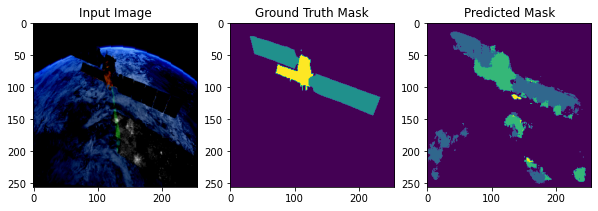

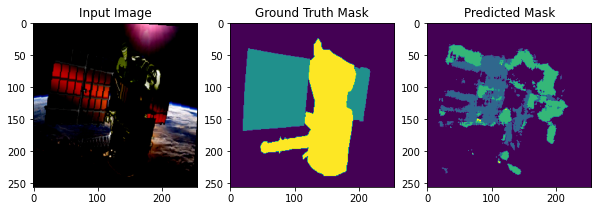

In [ ]:
# Segmentation output for 20 random images from the dataloader
arr = np.random.randint(402, size=(20))
for x in arr:
  show_out(train,x)

In [ ]:
# Loading one image from data loader for gradcam
# Load an image and corresponding mask
img_index = 1
image_gd, _ = train[1]
image_gd = image_gd.to(device)

In [ ]:
# Normalize image and compute segmentation output
normalized_inp = image_gd.unsqueeze(0)
# normalized_inp.requires_grad = True
out = model(normalized_inp)

# Find most likely segmentation class for each pixel.
out_max = torch.argmax(out, dim=1, keepdim=True)


In [ ]:
!pip install torchcam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Uncertainity in Segmentation using GradCAM
I make use of segmentation uncertainity by using GradCAM. The class activation maps are created per pixel for a particular class.

In [ ]:
from torchcam.methods import GradCAM
cam = GradCAM(model, [model.final[0]])
scores = model(image_gd.to(device).unsqueeze(0))
v = cam(class_idx=1, scores=scores)

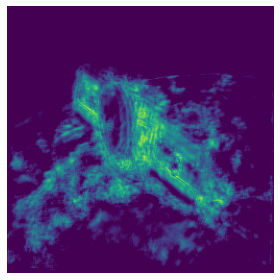

In [ ]:
import matplotlib.pyplot as plt
# Visualize the raw CAM
plt.imshow(v[0].cpu().squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

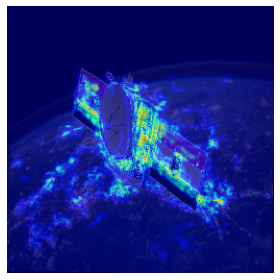

In [ ]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import normalize, resize, to_pil_image

# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(image_gd), to_pil_image(v[0].cpu().squeeze(0), mode='F'), alpha=0.3)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()